### Imports

In [1]:
import numpy as np, pandas as pd
import joblib, os
import matplotlib.pyplot as plt, seaborn as sns
sns.set_style("ticks")
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=UserWarning)
%load_ext autoreload
%autoreload 2
from scripts import farseeing, classifiers, utils

### Uncertainty-Aware Fall Detection
The test set is not segmented. `X_test` is the full 20-minute signal and `y_test` contains the fall points for each signal.

#### With 5-fold Cross-validation and Multiphase

In [2]:
# Tabular models
kwargs = dict(
	window_size=7, cv=5,
	segment_test=False,
	multiphase=True,
	model_type='tabular'
)
tab_metric_df, tab_aggr_df = classifiers.cross_validate(
	farseeing, **kwargs)
tab_metric_df['model_type'] = 'tabular'
tab_aggr_df['model_type'] = 'tabular'



-- fold 1, testing on (8 subjects) --
Train set: X: (2638, 700), y: (2638,) ([ADLs, Falls]) [2524  114]
Test set: X: 34, y: 34
⏳ TRAINING LogisticCV. RandomForest. ExtraTrees. ✅
🔍 TESTING LogisticCV. RandomForest. ExtraTrees. Ensemble. ✅


-- fold 2, testing on (8 subjects) --
Train set: X: (1659, 700), y: (1659,) ([ADLs, Falls]) [1587   72]
Test set: X: 46, y: 46
⏳ TRAINING LogisticCV. RandomForest. ExtraTrees. ✅
🔍 TESTING LogisticCV. RandomForest. ExtraTrees. Ensemble. ✅


-- fold 3, testing on (8 subjects) --
Train set: X: (1352, 700), y: (1352,) ([ADLs, Falls]) [1291   61]
Test set: X: 17, y: 17
⏳ TRAINING LogisticCV. RandomForest. ExtraTrees. ✅
🔍 TESTING LogisticCV. RandomForest. ExtraTrees. Ensemble. ✅


-- fold 4, testing on (8 subjects) --
Train set: X: (1136, 700), y: (1136,) ([ADLs, Falls]) [1091   45]
Test set: X: 18, y: 18
⏳ TRAINING LogisticCV. RandomForest. ExtraTrees. ✅
🔍 TESTING LogisticCV. RandomForest. ExtraTrees. Ensemble. ✅


-- fold 5, testing on (8 subjects) --


In [3]:
# ts models
kwargs = dict(
	window_size=7, cv=5,
	segment_test=False,
	multiphase=True,
	model_type='ts'
)
ts_metric_df, ts_aggr_df = classifiers.cross_validate(
	farseeing, **kwargs)
ts_metric_df['model_type'] = 'ts'
ts_aggr_df['model_type'] = 'ts'



-- fold 1, testing on (8 subjects) --
Train set: X: (2638, 700), y: (2638,) ([ADLs, Falls]) [2524  114]
Test set: X: 34, y: 34
⏳ TRAINING Rocket. Catch22. QUANT. ✅
🔍 TESTING Rocket. Catch22. QUANT. Ensemble. ✅


-- fold 2, testing on (8 subjects) --
Train set: X: (1659, 700), y: (1659,) ([ADLs, Falls]) [1587   72]
Test set: X: 46, y: 46
⏳ TRAINING Rocket. Catch22. QUANT. ✅
🔍 TESTING Rocket. Catch22. QUANT. Ensemble. ✅


-- fold 3, testing on (8 subjects) --
Train set: X: (1352, 700), y: (1352,) ([ADLs, Falls]) [1291   61]
Test set: X: 17, y: 17
⏳ TRAINING Rocket. Catch22. QUANT. ✅
🔍 TESTING Rocket. Catch22. QUANT. Ensemble. ✅


-- fold 4, testing on (8 subjects) --
Train set: X: (1136, 700), y: (1136,) ([ADLs, Falls]) [1091   45]
Test set: X: 18, y: 18
⏳ TRAINING Rocket. Catch22. QUANT. ✅
🔍 TESTING Rocket. Catch22. QUANT. Ensemble. ✅


-- fold 5, testing on (8 subjects) --
Train set: X: (815, 700), y: (815,) ([ADLs, Falls]) [790  25]
Test set: X: 29, y: 29
⏳ TRAINING Rocket. Catch22.

In [4]:
# save all dfs
all_metric_df = pd.concat([tab_metric_df, ts_metric_df], ignore_index=True)
all_aggr_df = pd.concat([tab_aggr_df, ts_aggr_df], ignore_index=True)
all_metric_df.to_csv('results/farseeing_all_metric_df_7_3sec.csv', index=False)
all_aggr_df.to_csv('results/farseeing_all_aggr_df_7_3sec.csv', index=False)

In [5]:
load_path = 'results/farseeing_all_metric_df_7_3sec.csv'
all_metric_df = pd.read_csv(load_path)
tab_metric_df = all_metric_df[all_metric_df['model_type'] == 'tabular']
ts_metric_df = all_metric_df[all_metric_df['model_type'] == 'ts']

In [ ]:
tab_metric_df.replace({'model': {'Ensemble': 'Tabular Ensemble'}}, inplace=True)
ts_metric_df.replace({'model': {'Ensemble': 'TS Ensemble'}}, inplace=True)
all_metric_df = pd.concat([tab_metric_df, ts_metric_df], ignore_index=True)

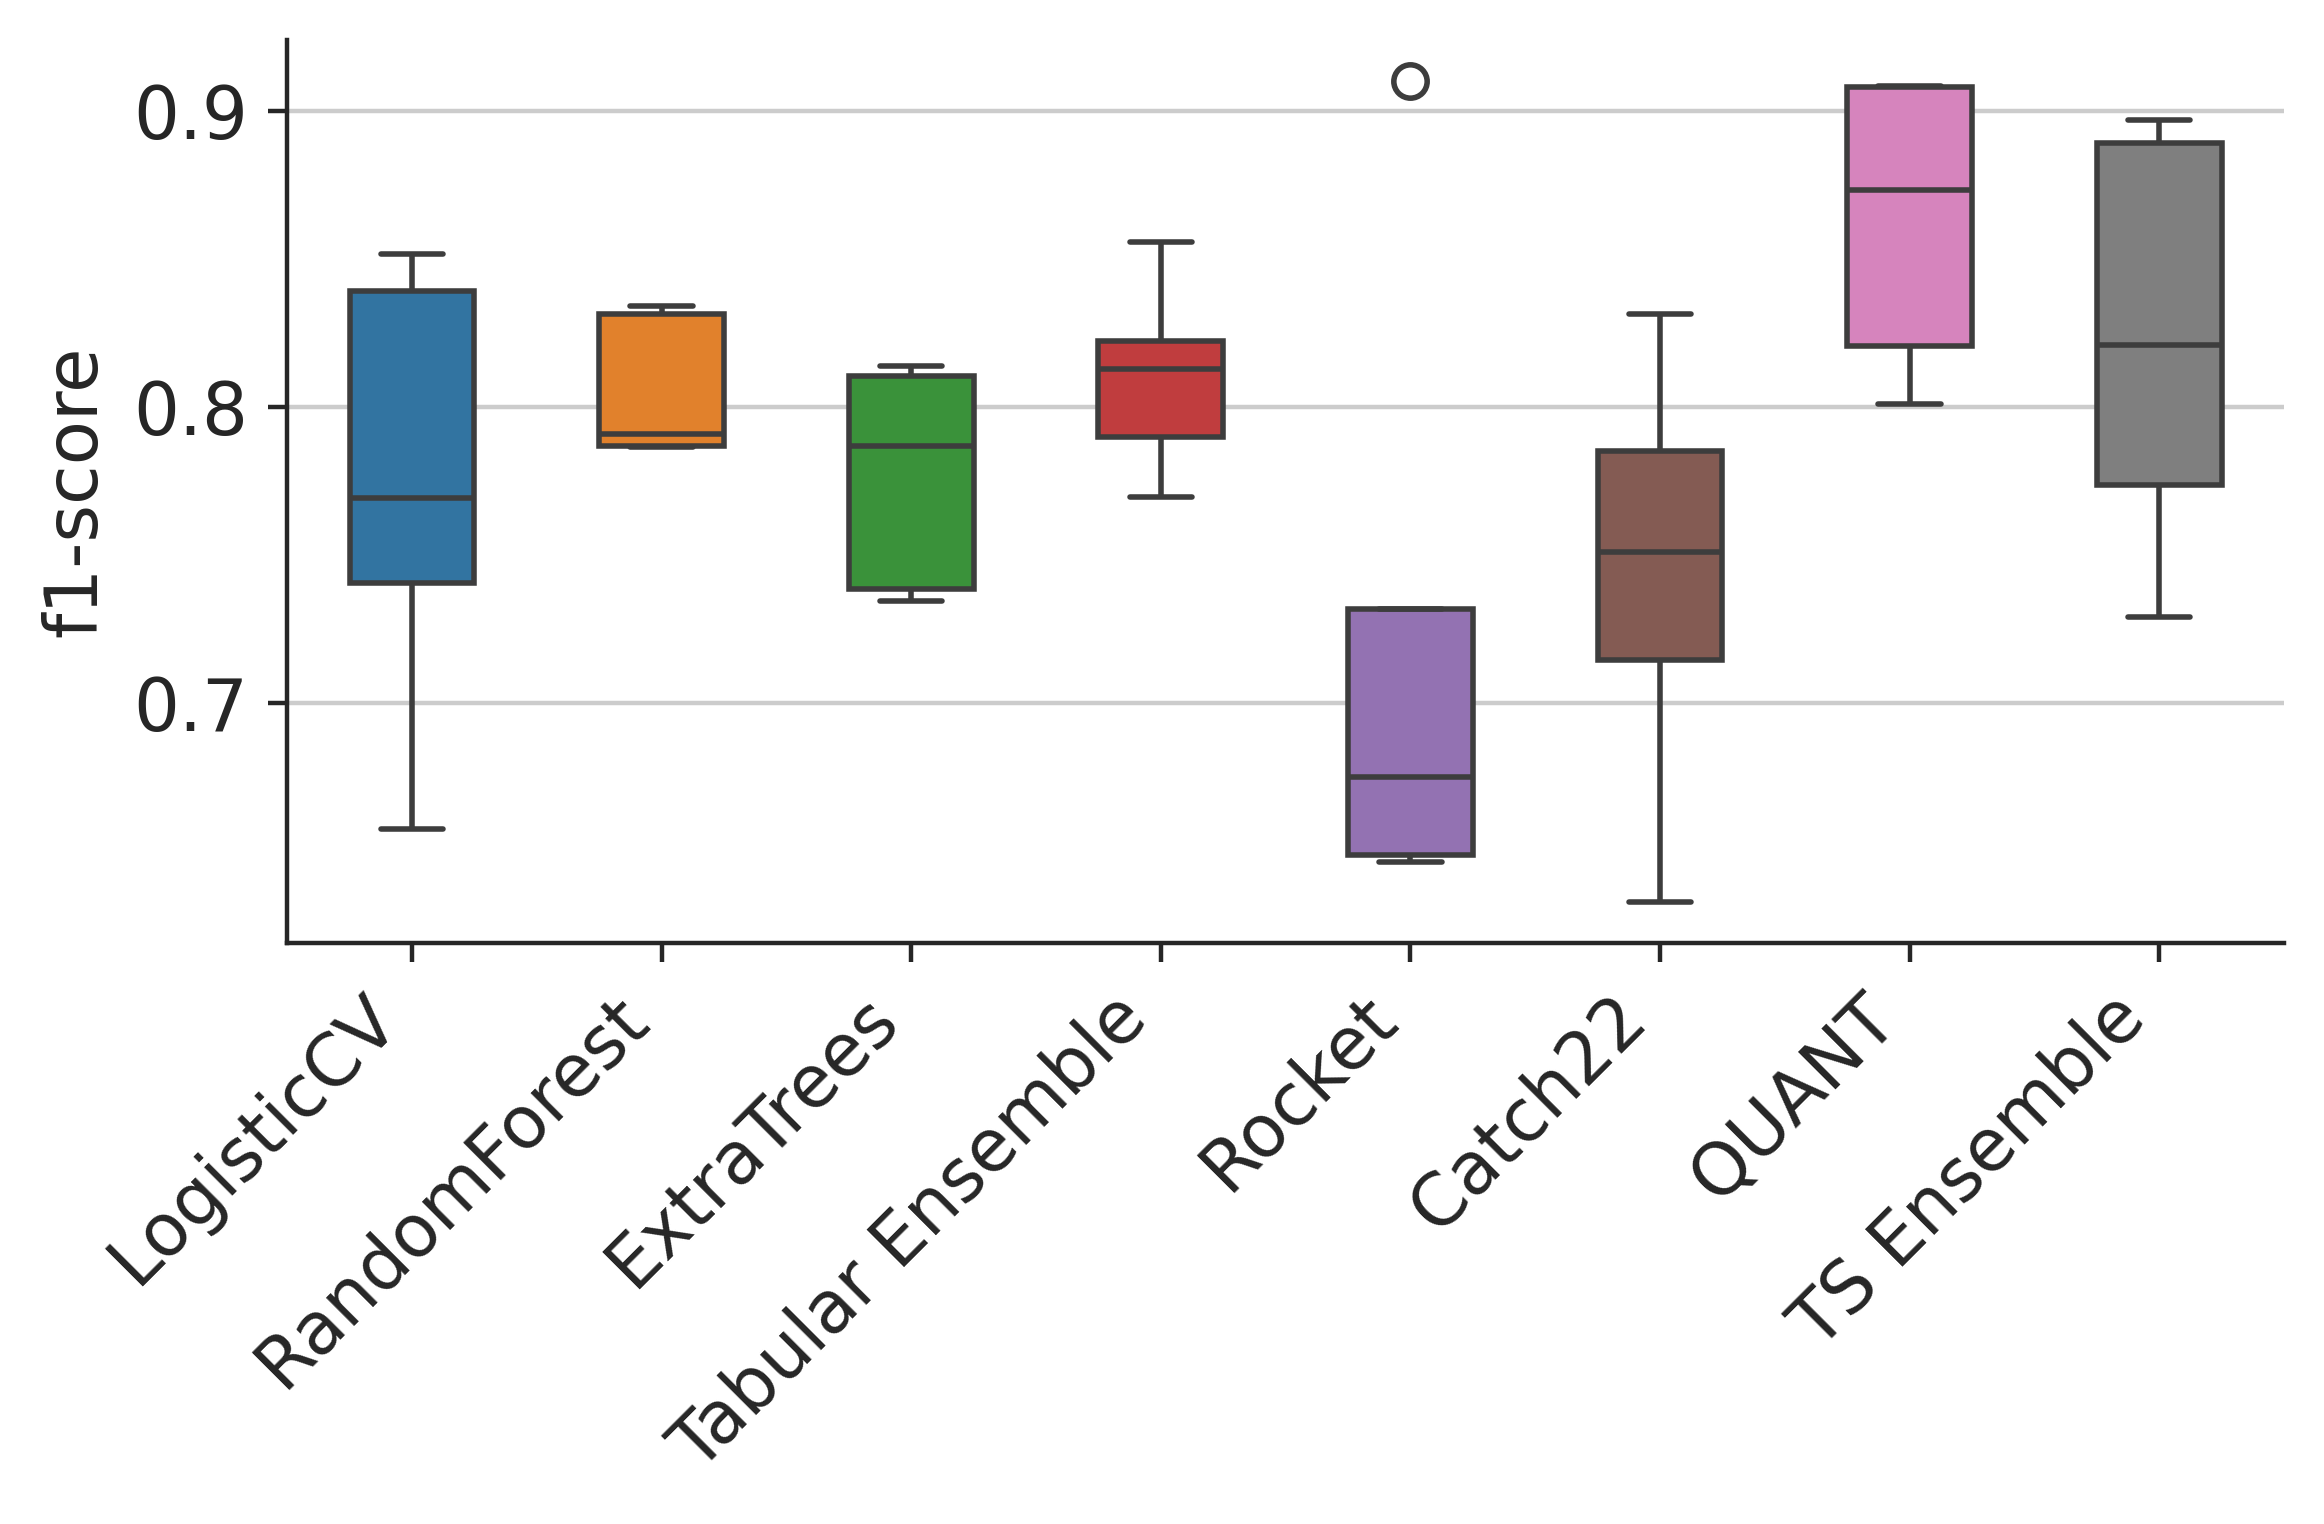

In [7]:
utils.summary_visualization([all_metric_df], name='all_models')

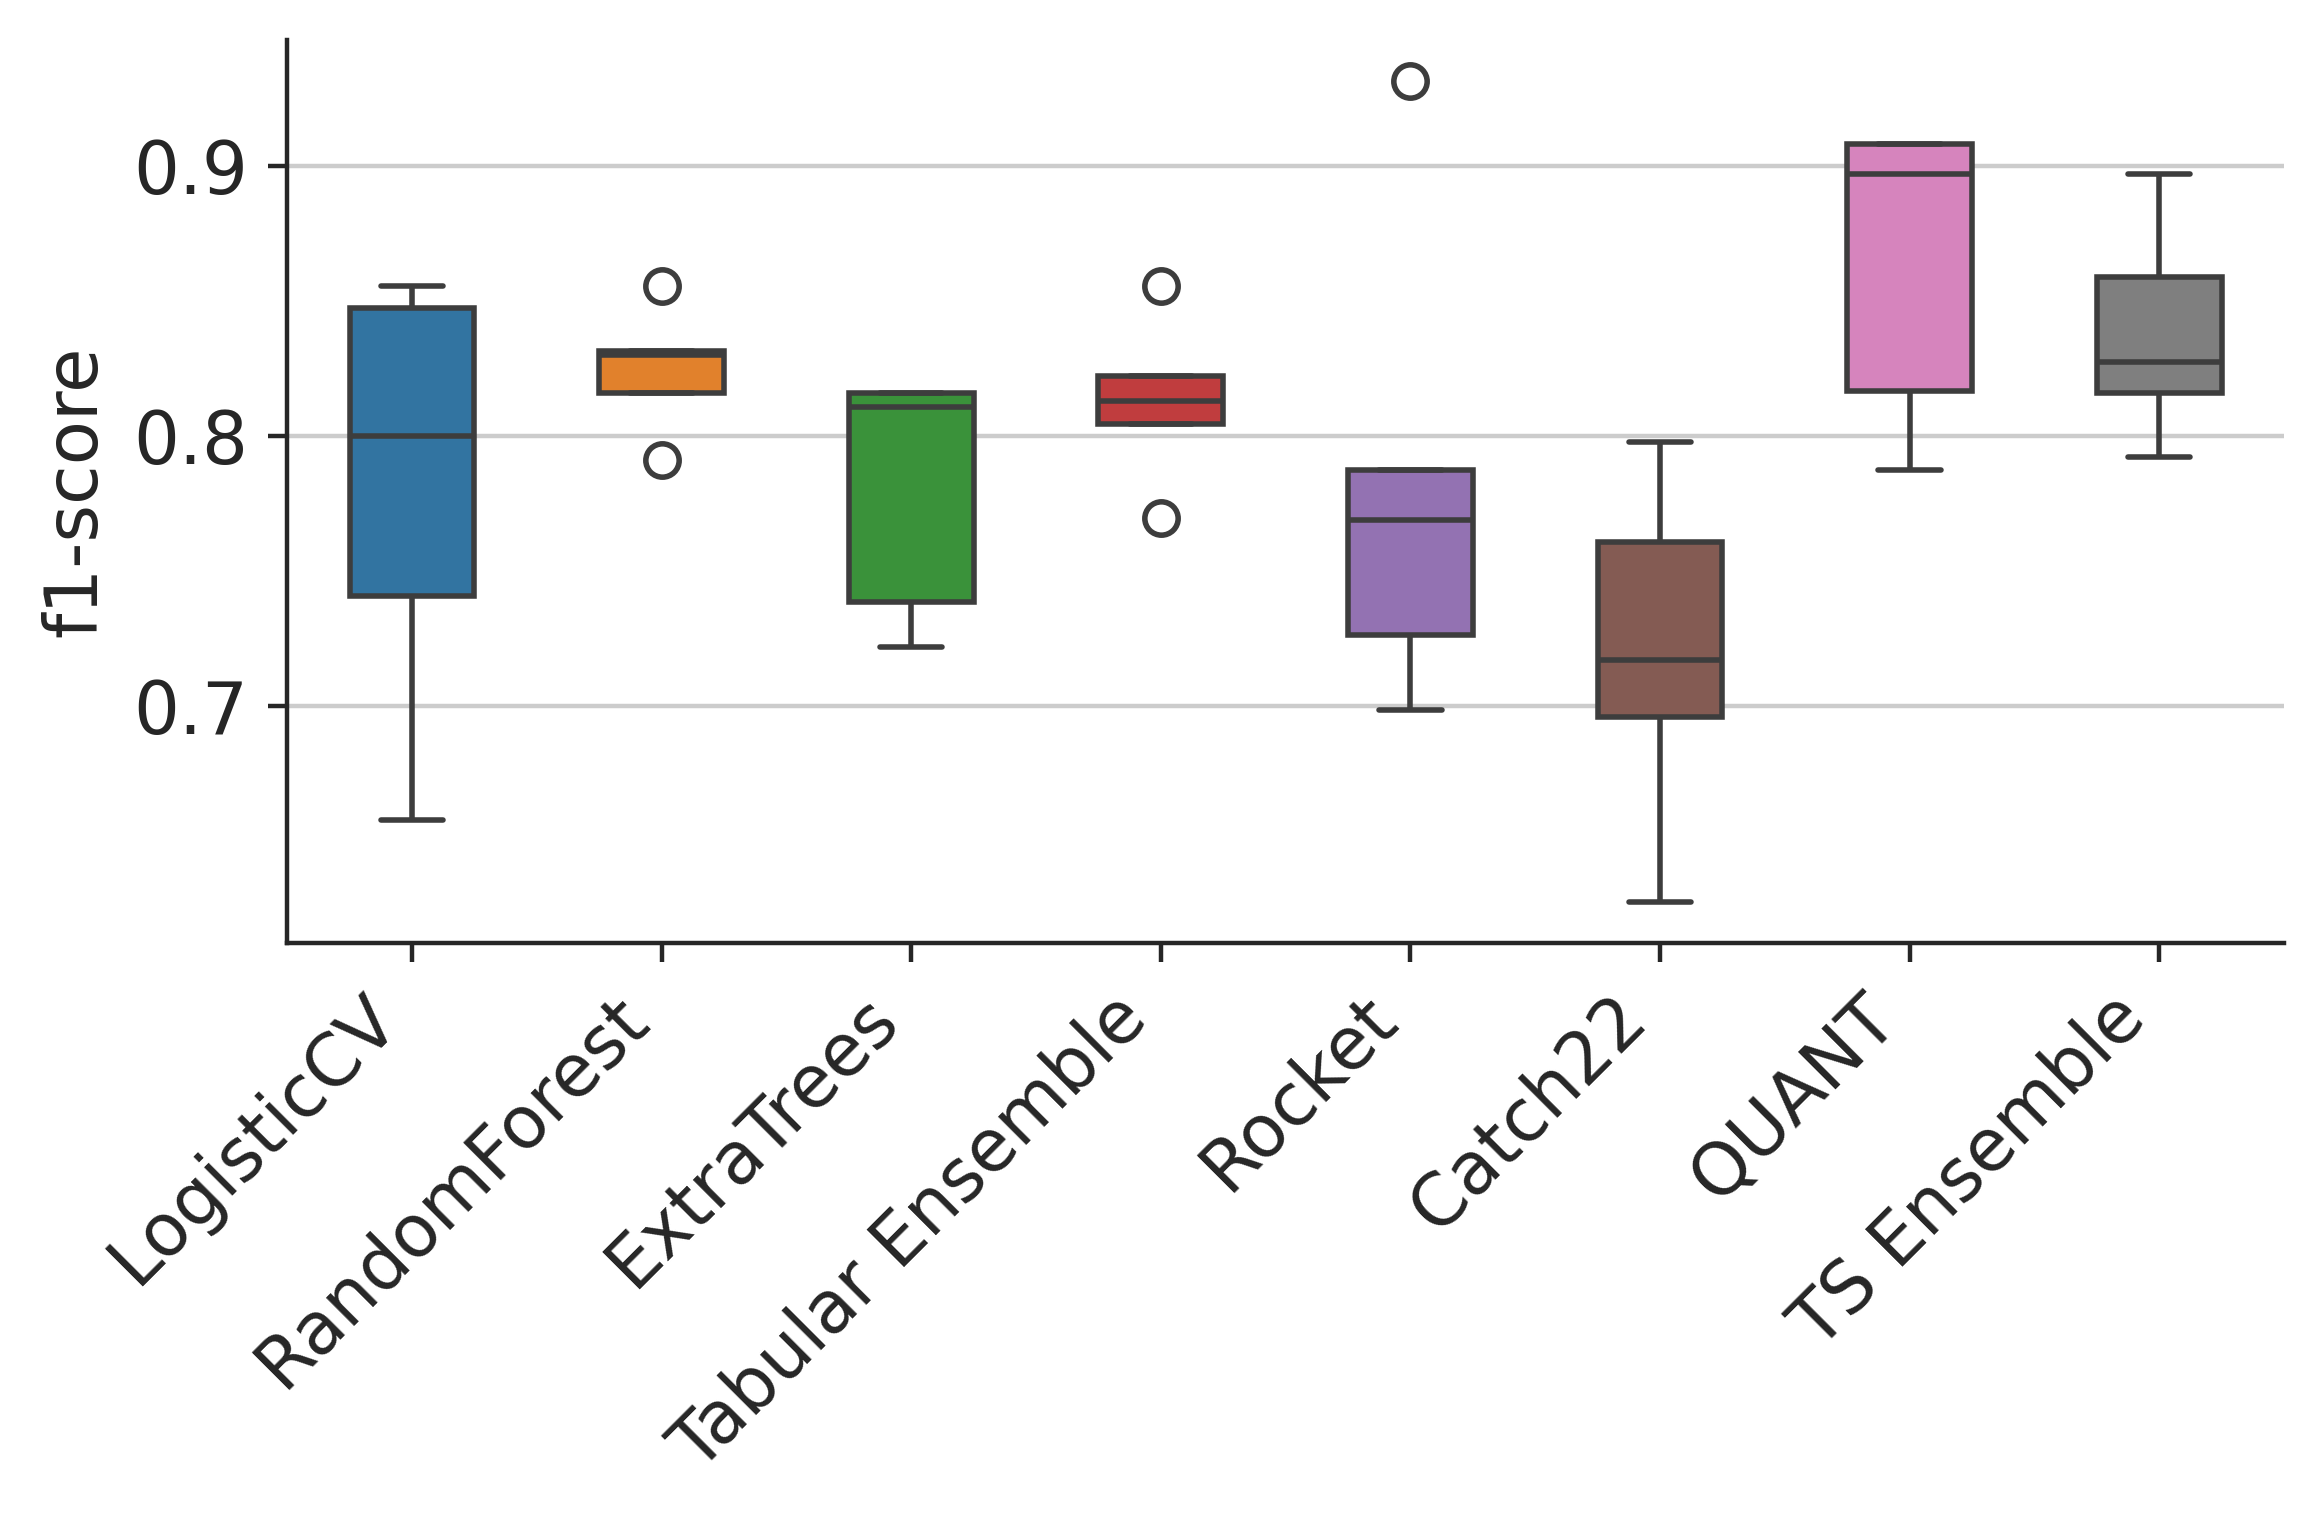

In [9]:
utils.summary_visualization([all_metric_df], name='all_models')

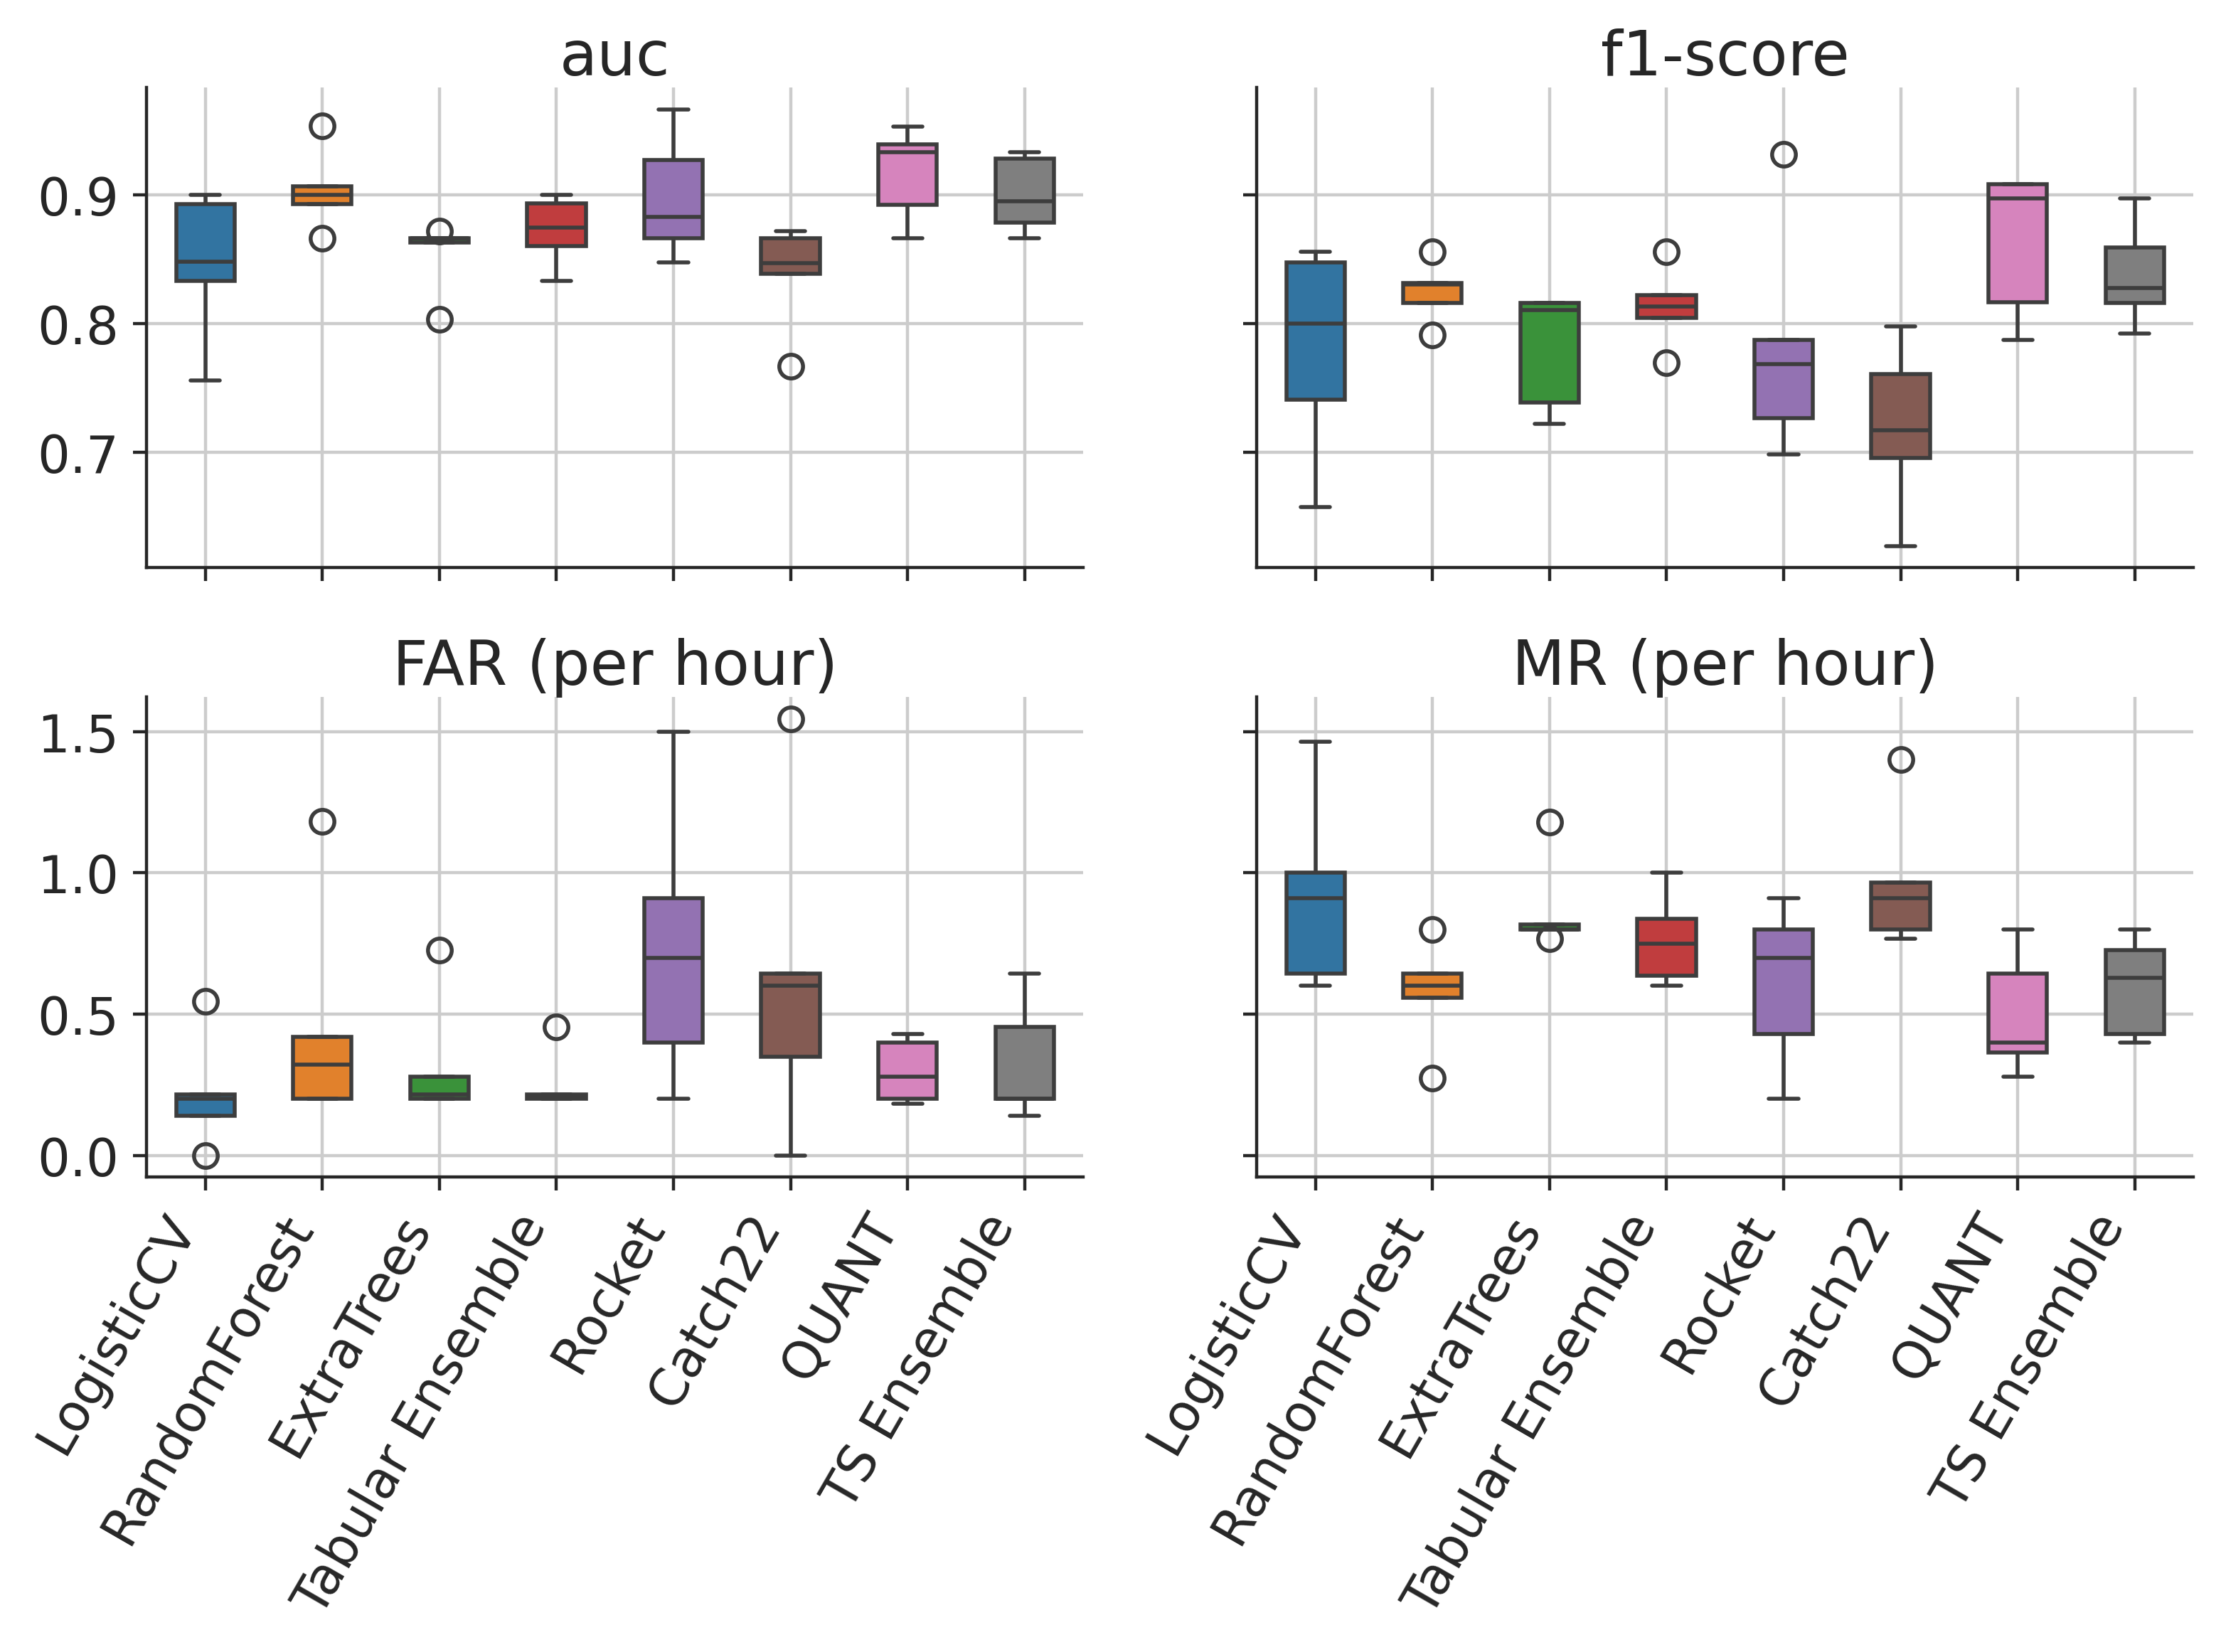

In [109]:
metrics = ['auc', 'f1-score',
           'false alarm rate', 'miss rate']
utils.visualise_all_metrics(all_metric_df, metrics=metrics)

#### Cost-sensitive

In [ ]:
kwargs = dict(
	window_size=7,
    multiphase=True,
	segment_test=False,
	tune_threshold=True)
dataset = utils.train_test_subjects_split(
    farseeing, **kwargs)

Train set: X: (3426, 700), y: (3426,)        ([ADLs, Falls]) [3314  112]
Test set: X: 34, y: 34


In [90]:
metrics_df = []
for t in [False, True]:
    kwargs['tune_threshold'] = t
    kwargs['models_subset'] = ['ExtraTrees']
    kwargs['plot'] = False
    df = classifiers.run_models(*dataset, **kwargs)
    df['threshold'] = 'auto' if t else 'default'
    metrics_df.append(df)
xtrees_df = pd.concat(metrics_df, ignore_index=True)
# metrics_df.to_csv('results/farseeing_tune_threshold_7sec.csv', index=False)

⏳ TRAINING ExtraTrees. ✅
🔍 TESTING ExtraTrees[[3.9598e+06 2.0000e+00]
 [4.0000e+00 2.9000e+01]]
. Ensemble. ✅
⏳ TRAINING ExtraTrees. Tuning threshold...
thresh: 0.4545454545454546 ✅
🔍 TESTING ExtraTrees[[3.9598e+06 2.0000e+00]
 [3.0000e+00 3.0000e+01]]
. Ensemble. ✅


In [91]:
xtrees_df

,model,window_size,runtime,auc,precision,recall,specificity,f1-score,false alarm rate,miss rate,g,threshold
0,ExtraTrees,7,0.471107,0.939394,0.94,0.878788,0.999999,0.908364,0.181817,0.363633,0.001,default
1,Ensemble,7,0.471107,0.939394,0.94,0.878788,0.999999,0.908364,0.181817,0.363633,0.001,default
2,ExtraTrees,7,0.486950,0.954545,0.94,0.909091,0.999999,0.924287,0.181817,0.272725,0.001,auto
3,Ensemble,7,0.486950,0.939394,0.94,0.878788,0.999999,0.908364,0.181817,0.363633,0.001,auto


In [94]:
metrics_df = []
kwargs['ensemble'] = False
kwargs['models_subset'] = None
for t in [False, True]:
    kwargs['tune_threshold'] = t
    for model_type in ['tabular', 'ts']:
        kwargs['model_type'] = model_type
        df = classifiers.run_models(*dataset, **kwargs)
        df['threshold'] = 'auto' if t else 'default'
        df['model_type'] = model_type
        metrics_df.append(df)
metrics_df = pd.concat(metrics_df, ignore_index=True)
metrics_df.to_csv('results/farseeing_tune_threshold_7sec.csv', index=False)

⏳ TRAINING LogisticCV. RandomForest. ExtraTrees. ✅
🔍 TESTING LogisticCV. RandomForest. ExtraTrees. . ✅
⏳ TRAINING Rocket. Catch22. QUANT. ✅
🔍 TESTING Rocket. Catch22. QUANT. . ✅
⏳ TRAINING LogisticCV. Tuning threshold...
thresh: 0.23232391950197182 RandomForest. Tuning threshold...
thresh: 0.36336700336700334 ExtraTrees. Tuning threshold...
thresh: 0.4545454545454546 ✅
🔍 TESTING LogisticCV. RandomForest. ExtraTrees. . ✅
⏳ TRAINING Rocket. Tuning threshold...
thresh: 0.010101010101010102 Catch22. Tuning threshold...
thresh: 0.2939393939393939 QUANT. Tuning threshold...
thresh: 0.3535353535353536 ✅
🔍 TESTING Rocket. Catch22. QUANT. . ✅


In [95]:
metrics_df.sort_values(by=['model'])

,model,window_size,runtime,auc,precision,recall,specificity,f1-score,false alarm rate,miss rate,g,threshold,model_type
4,Catch22,7,21.464582,0.863636,0.89,0.727273,0.999999,0.800450,0.272725,0.818175,0.001,default,ts
10,Catch22,7,16.672135,0.939392,0.67,0.878788,0.999996,0.760321,1.272717,0.363633,0.001,auto,ts
2,ExtraTrees,7,0.479098,0.939394,0.94,0.878788,0.999999,0.908364,0.181817,0.363633,0.001,default,tabular
8,ExtraTrees,7,0.564419,0.954545,0.94,0.909091,0.999999,0.924287,0.181817,0.272725,0.001,auto,tabular
0,LogisticCV,7,0.122435,0.878787,0.83,0.757576,0.999999,0.792136,0.454542,0.727267,0.001,default,tabular
6,LogisticCV,7,0.128656,0.954544,0.77,0.909091,0.999998,0.833785,0.818175,0.272725,0.001,auto,tabular
5,QUANT,7,4.122839,0.954545,0.88,0.909091,0.999999,0.894309,0.363633,0.272725,0.001,default,ts
11,QUANT,7,4.242506,0.984848,0.84,0.969697,0.999998,0.900201,0.545450,0.090908,0.001,auto,ts
1,RandomForest,7,0.172765,0.954544,0.79,0.909091,0.999998,0.845372,0.727267,0.272725,0.001,default,tabular
7,RandomForest,7,0.169083,0.969696,0.76,0.939394,0.999997,0.840228,0.909083,0.181817,0.001,auto,tabular


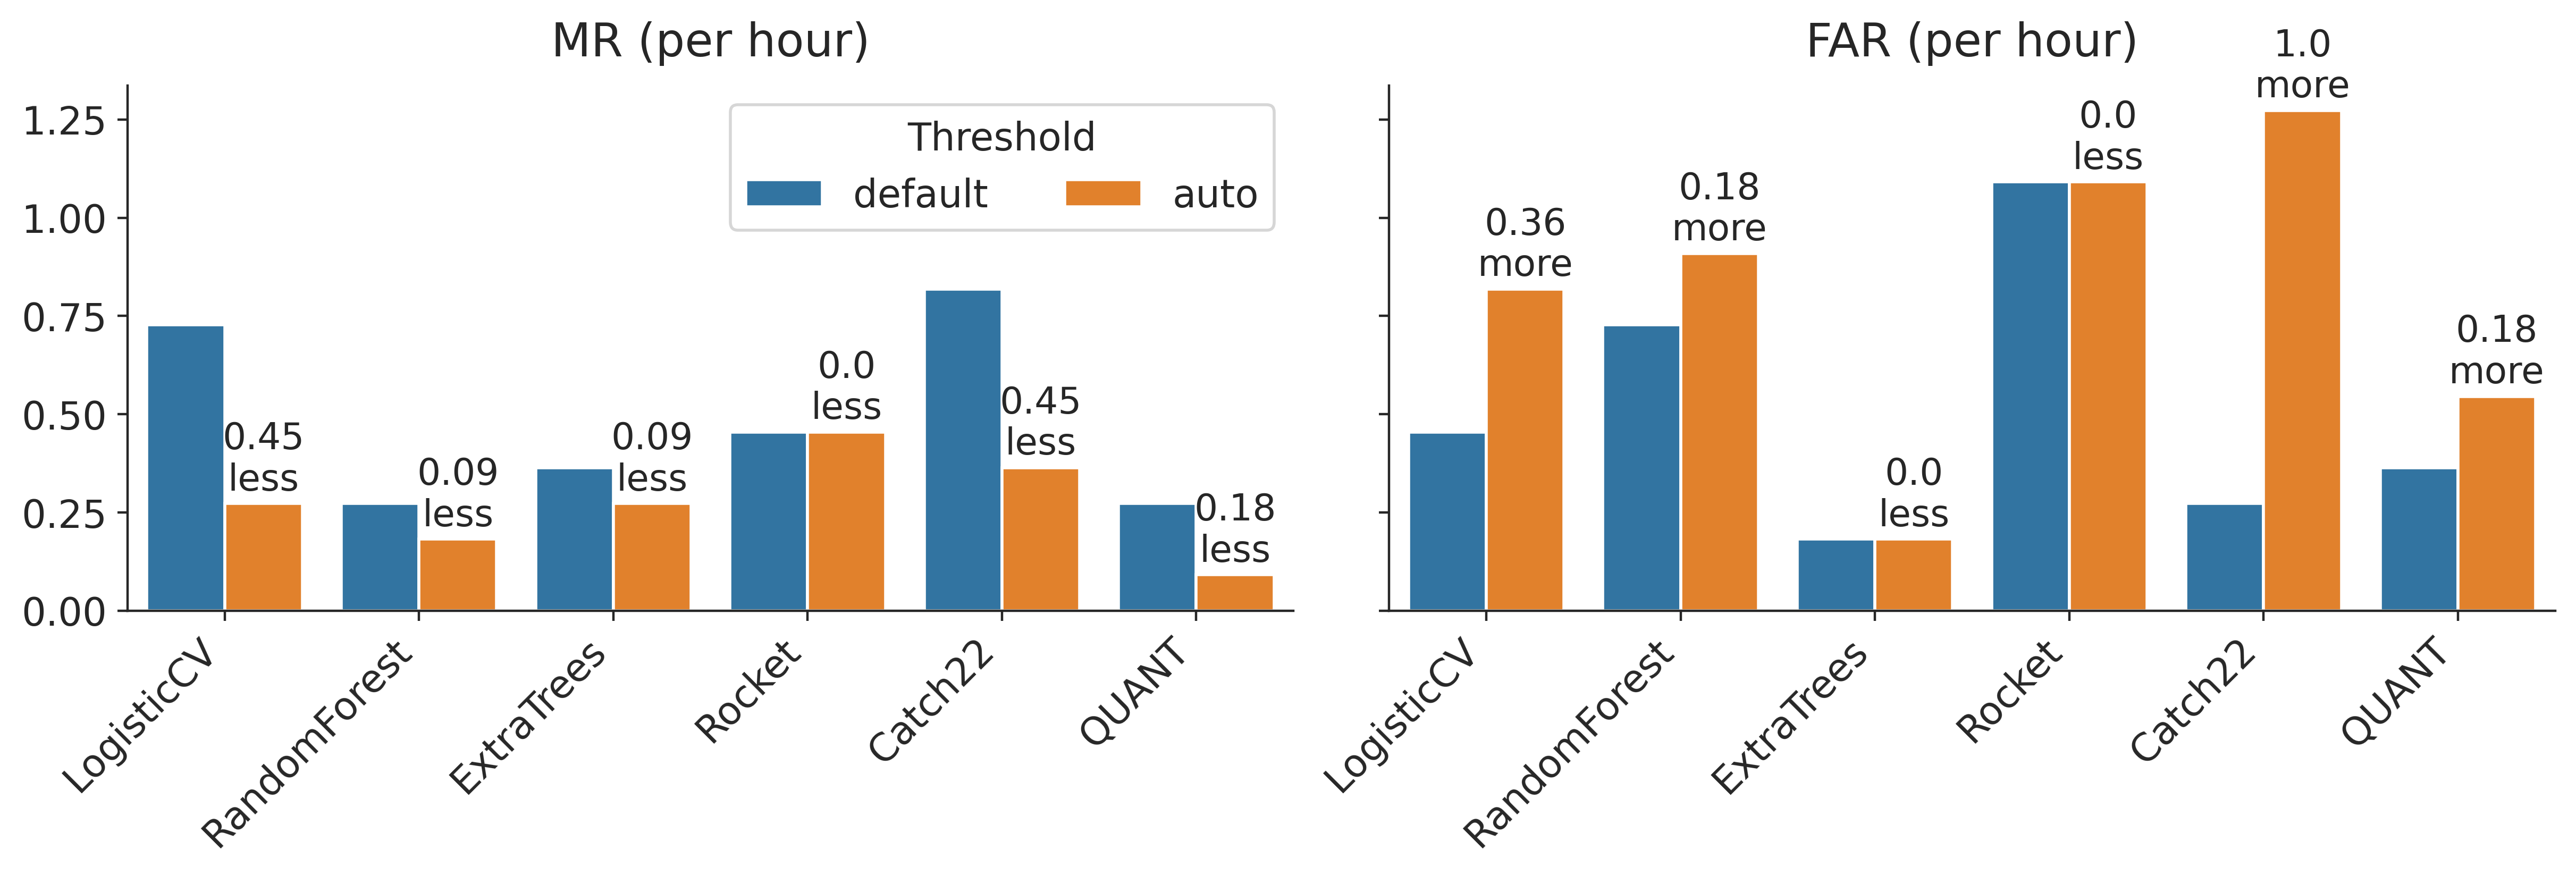

In [158]:
fig, ax = plt.subplots(1, 2, figsize=(12, 4), dpi=400,
					   sharey=True, layout='constrained')
for i, m in enumerate(['miss rate', 'false alarm rate']):
	sns.barplot(data=metrics_df, x='model', y=m, hue='threshold',
			 ax=ax[i], palette='tab10')
	labels1 = [x for x in ax[i].containers[0].datavalues] # Round up container[0] values
	labels2 = [x for x in ax[i].containers[1].datavalues] # Round up container[1] values
	improvements = [np.round(b-a,2) for a, b in zip(labels1, labels2)] # Calculate improvements
	lbls = [f'{i}\nmore' if i > 0 else f'{abs(i)}\nless' for i in improvements] # Annotate using rounded values
	# Annotate using rounded values
	ax[i].bar_label(ax[i].containers[1], labels=lbls, fontsize=12.5, padding=2)
	ax[i].set_xticklabels(ax[i].get_xticklabels(), rotation=45, ha='right')
	m = 'FAR (per hour)' if m == 'false alarm rate' else m
	m = 'MR (per hour)' if m == 'miss rate' else m
	ax[i].set_title(m, pad=10)
	ax[i].set_xlabel('')
	ax[i].set_ylabel('')
	# only show legend for the last plot
	if i > 0:
		ax[i].get_legend().remove()
	else:
		ax[i].legend(title='Threshold', ncols=2)
sns.despine()
plt.savefig('figs/barplot_tune_threshold_7sec.pdf',
			dpi=400, bbox_inches='tight')
plt.show()

#### Cost sensitivity analysis

In [187]:
# Run through a range of FN factors and see the effect on the metrics
tune_df = []
kwargs['ensemble'] = False
kwargs['models_subset'] = None
kwargs['tune_threshold'] = True
for fn_factor in np.arange(2, 20, 2):
	kwargs['fn_factor'] = fn_factor
	df = classifiers.run_models(*dataset, **kwargs)
	df['fn_factor'] = fn_factor
	tune_df.append(df)
tune_df = pd.concat(tune_df, ignore_index=True)
tune_df.to_csv('results/sensitivity_analysis.csv', index=False)

⏳ TRAINING Rocket. Tuning threshold...
thresh: 0.010101010101010102 Catch22. Tuning threshold...
thresh: 0.35272727272727267 QUANT. Tuning threshold...
thresh: 0.3535353535353536 ✅
🔍 TESTING Rocket. Catch22. QUANT. . ✅
⏳ TRAINING Rocket. Tuning threshold...
thresh: 0.010101010101010102 Catch22. Tuning threshold...
thresh: 0.2939393939393939 QUANT. Tuning threshold...
thresh: 0.3535353535353536 ✅
🔍 TESTING Rocket. Catch22. QUANT. . ✅
⏳ TRAINING Rocket. Tuning threshold...
thresh: 0.010101010101010102 Catch22. Tuning threshold...
thresh: 0.2939393939393939 QUANT. Tuning threshold...
thresh: 0.3535353535353536 ✅
🔍 TESTING Rocket. Catch22. QUANT. . ✅
⏳ TRAINING Rocket. Tuning threshold...
thresh: 0.010101010101010102 Catch22. Tuning threshold...
thresh: 0.2939393939393939 QUANT. Tuning threshold...
thresh: 0.3535353535353536 ✅
🔍 TESTING Rocket. Catch22. QUANT. . ✅
⏳ TRAINING Rocket. Tuning threshold...
thresh: 0.010101010101010102 Catch22. Tuning threshold...
thresh: 0.2939393939393939 QUA

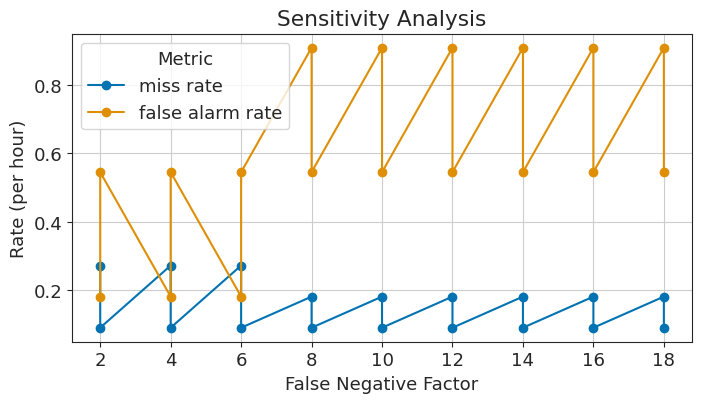

In [182]:
quant_metrics_df.plot(x='fn_factor', y=['miss rate', 'false alarm rate'],
					  kind='line', marker='o', figsize=(8, 4), grid=True)
plt.xlabel('False Negative Factor')
plt.ylabel('Rate (per hour)')
plt.title('Sensitivity Analysis')
plt.legend(title='Metric')
# plt.savefig('figs/sensitivity_analysis.pdf', dpi=400, bbox_inches='tight')
plt.show()

In [184]:
quant_metrics_df

,model,window_size,runtime,auc,precision,recall,specificity,f1-score,false alarm rate,miss rate,g,fn_factor
0,ExtraTrees,7,0.464314,0.954545,0.94,0.909091,0.999999,0.924287,0.181817,0.272725,0.001,2
1,QUANT,7,4.231537,0.984848,0.84,0.969697,0.999998,0.900201,0.545450,0.090908,0.001,2
2,ExtraTrees,7,0.461912,0.954545,0.94,0.909091,0.999999,0.924287,0.181817,0.272725,0.001,4
3,QUANT,7,4.247642,0.984848,0.84,0.969697,0.999998,0.900201,0.545450,0.090908,0.001,4
4,ExtraTrees,7,0.482233,0.954545,0.94,0.909091,0.999999,0.924287,0.181817,0.272725,0.001,6
5,QUANT,7,4.256110,0.984848,0.84,0.969697,0.999998,0.900201,0.545450,0.090908,0.001,6
6,ExtraTrees,7,0.462802,0.969696,0.76,0.939394,0.999997,0.840228,0.909083,0.181817,0.001,8
7,QUANT,7,4.250642,0.984848,0.84,0.969697,0.999998,0.900201,0.545450,0.090908,0.001,8
8,ExtraTrees,7,0.478242,0.969696,0.76,0.939394,0.999997,0.840228,0.909083,0.181817,0.001,10
9,QUANT,7,4.221790,0.984848,0.84,0.969697,0.999998,0.900201,0.545450,0.090908,0.001,10


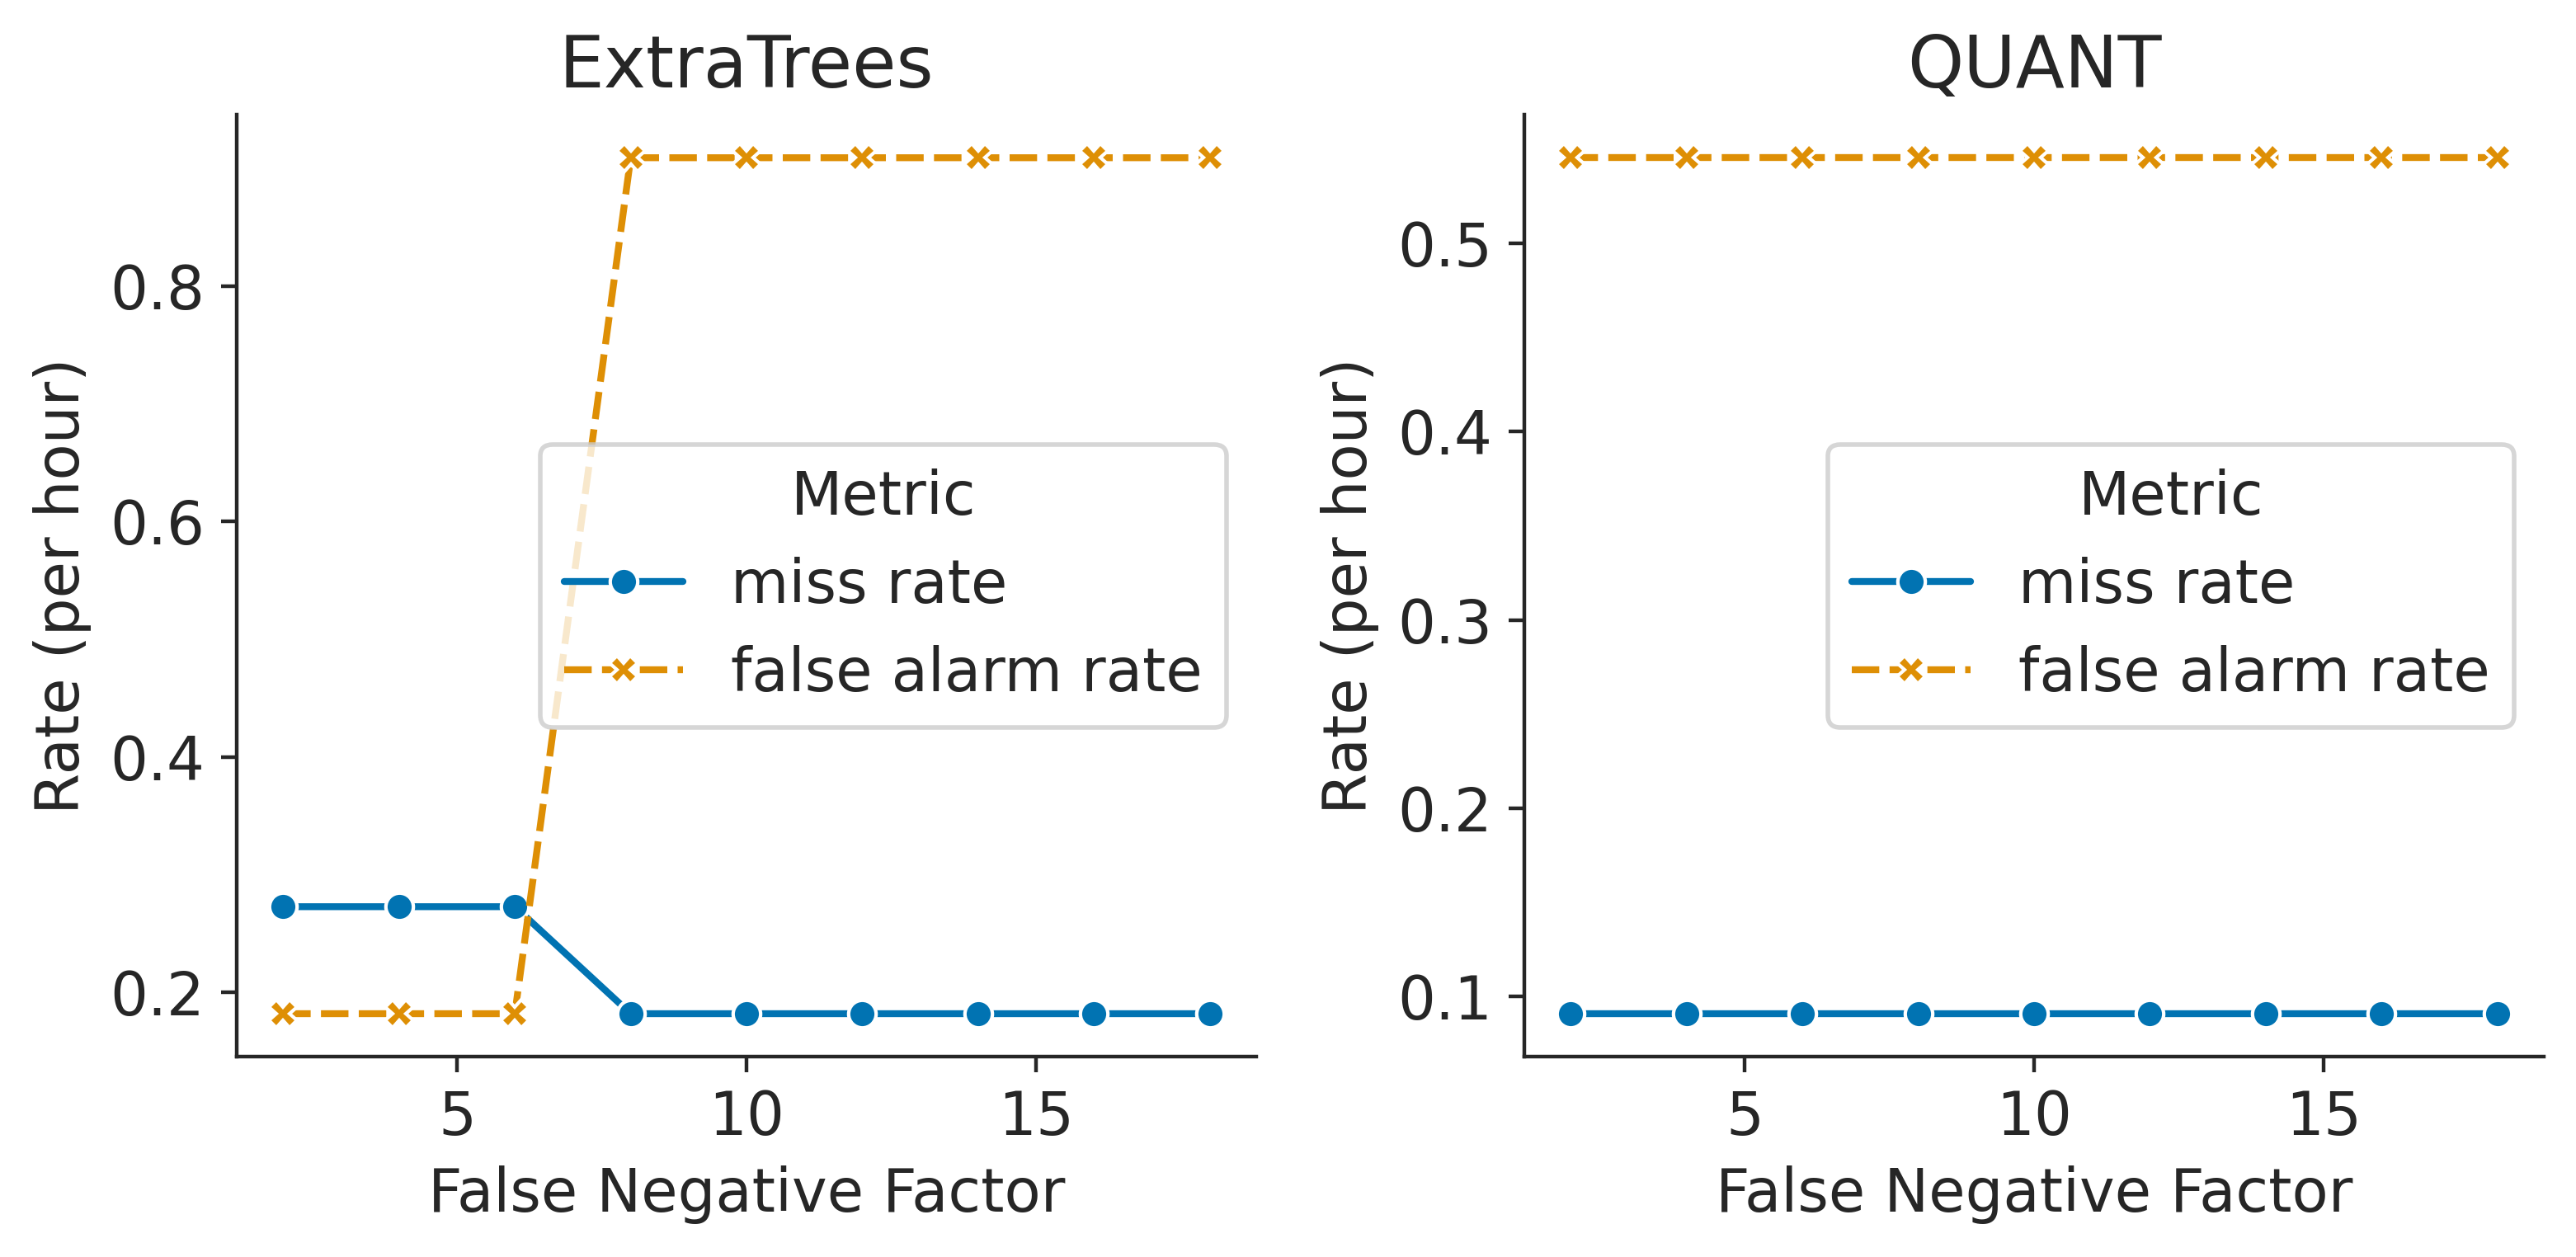

In [183]:
long_sens_df = quant_metrics_df.melt(id_vars=['model', 'fn_factor'],
									  value_vars=['miss rate', 'false alarm rate'],
									  var_name='metric', value_name='rate')
fig, ax = plt.subplots(1, 2, figsize=(8, 4), dpi=400)
for i, model in enumerate(long_sens_df['model'].unique()):
	sns.lineplot(data=long_sens_df[long_sens_df['model'] == model],
				 x='fn_factor', y='rate', hue='metric', style='metric',
				 markers=True, ax=ax[i])
	ax[i].set_title(model)
	ax[i].set_xlabel('False Negative Factor')
	ax[i].set_ylabel('Rate (per hour)')
	ax[i].legend(title='Metric')
sns.despine()
plt.tight_layout()
# plt.savefig('figs/sensitivity_analysis_long.pdf', dpi=400, bbox_inches='tight')
plt.show()